# Skin Cancer Detection models 🩺 | BaseLine Model, CNN, NN and Logistic Regression

#### Prologue
This notebook explores melanoma classification using machine learning.
The objective is **construct** and **analyze** four models: baseLine Model, neural network, logistic regression, and a CNN.

#### Dataset Overview
Comprising 13,900 uniformly-sized images at 224 x 224 pixels, which provides a comprehensive portrayal of diverse manifestations of melanoma. Each image is meticulously labeled as either `benign` or `malignant`.

In [1]:
import asyncio
asyncio.set_event_loop_policy(asyncio.WindowsSelectorEventLoopPolicy())
#----------
import os
import random
#----------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.compat.v1 import reset_default_graph

#----------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, precision_score, recall_score
#----------
import pandas as pd
#----------
import matplotlib.pyplot as plt
#----------
import numpy as np
#----------
from PIL import Image
#----------
import warnings
warnings.filterwarnings('ignore')
#----------
import seaborn as sns
#----------
from IPython.display import Image

## Load and preprocess the dataset

In [2]:
# Path to the dataset archive
archive_path = r'C:\Users\yair8\Skin-Cancer-Detection-Project\dataSet'

In [3]:
# Define the main folder path after extraction
main_folder_path = os.path.splitext(archive_path)[0]  # Remove the extension

The main folder contains 2 folders - train and test - and each of them conatins 2 folder - Benign and Malignant

In [4]:
# Define subfolders
data_folders = ["train", "test"]
class_folders = ["Benign", "Malignant"]

In [5]:
# Paths for train and test data
train_data_path = os.path.join(main_folder_path, data_folders[0])
test_data_path = os.path.join(main_folder_path, data_folders[1])

print("Train Data Path:", train_data_path)
print("Test Data Path:", test_data_path)

print("Train folder content:")
for item in os.listdir(train_data_path):
    print(f"- {item}")

print("Test folder content:")
for item in os.listdir(test_data_path):
    print(f"- {item}")

Train Data Path: C:\Users\yair8\Skin-Cancer-Detection-Project\dataSet\train
Test Data Path: C:\Users\yair8\Skin-Cancer-Detection-Project\dataSet\test
Train folder content:
- Benign
- Malignant
Test folder content:
- Benign
- Malignant


Set hyperparamaters 

In [6]:
img_width, img_height = 112, 112 
batch_size = 32
epochs = 15    

In [7]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
def plotCount(generator):
    # ספירת כמות התמונות בקטגוריות Benign ו-Malignant
    malignant_count = sum(generator.labels == 1)
    benign_count = sum(generator.labels == 0)
    total_count = len(generator.labels)

    print(f"Total images is {total_count}")
    print(f"Total malignant images is {malignant_count} ({round(malignant_count / total_count * 100, 2)}%)")
    print(f"Total benign images is {benign_count} ({round(benign_count / total_count * 100, 2)}%)")

    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))
    sns.countplot(x=generator.labels)
    plt.title("Image Count for Benign vs Malignant")
    plt.xlabel("Label (0=Benign, 1=Malignant)")
    plt.ylabel("Count")
    plt.show()

Total images is 11879
Total malignant images is 5590 (47.06%)
Total benign images is 6289 (52.94%)


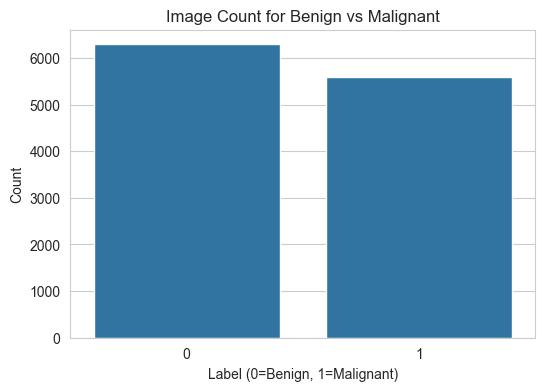

In [9]:
plotCount(train_generator)

Total images is 2000
Total malignant images is 1000 (50.0%)
Total benign images is 1000 (50.0%)


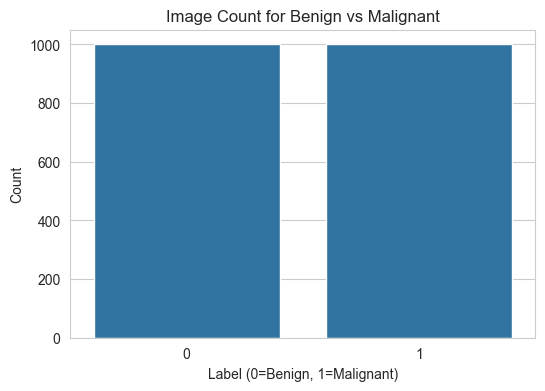

In [10]:
plotCount(test_generator)

# Models

This section involves constructing three models: a Neural Network (NN), Logistic Regression, and Convolutional Neural Network (CNN). Each model is analyzed individually, followed by a comparative evaluation to discern their respective performance characteristics.

## BaseLine Model

### Creation

In [11]:
def create_baseline_model(train_generator):
      # Extract all labels from the entire dataset (train_generator.classes)
    labels = train_generator.classes

    # Find the most frequent class (numeric index)
    majority_class_index = np.argmax(np.bincount(labels))

    for class_name, index in train_generator.class_indices.items():
        if index == majority_class_index:
            print(f"The majority class is: {class_name} (Index: {majority_class_index})")
            break

    return majority_class_index

### Training and Evaluating

In [12]:
def evaluate_baseline_model(majority_class_index, test_generator):

    true_labels = test_generator.classes

    predicted_labels = np.full_like(true_labels, fill_value=majority_class_index)

    return predicted_labels, true_labels

### Training Results

In [13]:
# Create the baseline model
baseline_majority_class = create_baseline_model(train_generator)

# Evaluate the baseline model
baseline_predictions, baseline_true_labels = evaluate_baseline_model(baseline_majority_class, test_generator)

# Display results
print(f"Baseline Predictions (first 1001): {baseline_predictions[:1001]}")
print(f"True Labels (first 1001): {baseline_true_labels[:1001]}")

The majority class is: Benign (Index: 0)
Baseline Predictions (first 1001): [0 0 0 ... 0 0 0]
True Labels (first 1001): [0 0 0 ... 0 0 1]


### Model Evaluation Metrics

In [14]:
def evaluate_model_performance(true_labels, predicted_labels, pos_label=1):

    mse = mean_squared_error(true_labels, predicted_labels)

    accuracy = accuracy_score(true_labels, predicted_labels) * 100

    precision = precision_score(true_labels, predicted_labels, pos_label=pos_label) * 100

    recall = recall_score(true_labels, predicted_labels, pos_label=pos_label) * 100

    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")

    return accuracy, precision, recall, mse


In [15]:
evaluate_model_performance(baseline_true_labels, baseline_predictions)

Mean Squared Error: 0.50
Accuracy: 50.00%
Precision: 0.00%
Recall: 0.00%


(50.0, 0.0, 0.0, 0.5)

### Classification Report

In [16]:
# Generate classification report
baseline_report = classification_report(
    baseline_true_labels,
    baseline_predictions,
    target_names=list(test_generator.class_indices.keys())
)

# Display the classification report
print("\nClassification Report:\n")
print(baseline_report)

# Accuracy = Number of correct predictions/Total number of samples
# Precision = True Positives*(True Positives+False Positives)  
# Recall = True Positives*(True Positives+False Negatives) 
# F1 Score = ((Precision⋅Recall)*2)/(Precision+Recall) 
# Support = the number of true examples from each class 
# Macro avg = a simple average of all the indices between the classes.
# Weighted avg = the weighted average of all the indices between the classes, considering the number of true examples from each class.


Classification Report:

              precision    recall  f1-score   support

      Benign       0.50      1.00      0.67      1000
   Malignant       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



### Confusion Matrix

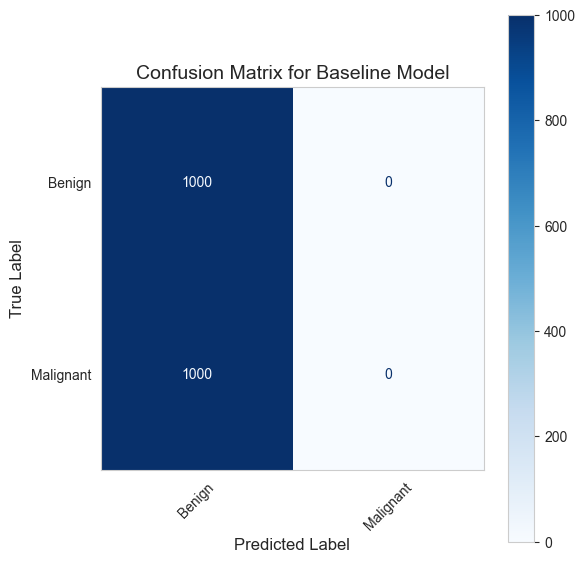

In [17]:
baseline_cm = confusion_matrix(baseline_true_labels, baseline_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=baseline_cm, display_labels=["Benign", "Malignant"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix for Baseline Model", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
reset_default_graph()

## Neural Network 

### Creation

In [19]:
def create_nn(num_hidden_layers, hidden_layer_sizes, learning_rate=0.0001):
    """
    Create a neural network with dynamic hidden layers and a specified learning rate.

    Parameters:
    - num_hidden_layers: Integer specifying the number of hidden layers for each set of sizes.
    - hidden_layer_size: List of integers specifying the size of each hidden layer.
    - learning_rate: Float specifying the learning rate.
    """
    model = Sequential()
    
    # Flatten the input data
    model.add(Flatten(input_shape=(img_width, img_height, 3)))

    # Add hidden layers with dropout
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(hidden_layer_sizes[i], activation='relu'))
            
    # Output layer with binary classification
    model.add(Dense(1, activation='sigmoid')) 

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model

In [20]:
# Define NN sizes
hidden_layer_sizes = [128, 64, 64]
num_hidden_layers = len(hidden_layer_sizes)

# Get the NN model
nn_model = create_nn(num_hidden_layers, hidden_layer_sizes)

# Display the model architecture
nn_model.summary()

# Output Shape: specifies the size of the output for each layer.
# Param:specifies the number of parameters (weights and biases) learned for each layer.
# (The number of neurons in the previous layer) * (The number of neurons in the current layer) + (The number of biases in the current layer)
# For example: The first layer has 128*112*112*3 + 128 = 4,817,024 parameters (+128 biases)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,817,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,505 (18.42 MB)

 Trainable params: 4,829,505 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training and evaluating

In [21]:
# Define the callback to use TensorBoard
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model with TensorBoard callback
history = nn_model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[tensorboard_callback])

Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.6873 - loss: 0.5758 - val_accuracy: 0.7155 - val_loss: 0.4975
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - accuracy: 0.7928 - loss: 0.4348 - val_accuracy: 0.6460 - val_loss: 0.7077
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8072 - loss: 0.4157 - val_accuracy: 0.6845 - val_loss: 0.5370
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.8120 - loss: 0.4025 - val_accuracy: 0.7665 - val_loss: 0.4547
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.8212 - loss: 0.3807 - val_accuracy: 0.8090 - val_loss: 0.4088
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 68ms/step - accuracy: 0.8342 - loss: 0.3690 - val_accuracy: 0.7840 - val_loss: 0.4129
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.8357 - loss: 0.3639 - val_accuracy: 0.7520 - val_loss: 0.4570
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.8366 - loss: 0.3612 - 

In [22]:
last_val_accuracy = history.history['val_accuracy'][-1]

print(f"Test Accuracy: {last_val_accuracy}")

Test Accuracy: 0.8389999866485596


### Training Results

In [23]:
def plot_history(history, name, metric):

    label_val = 'val_%s' % metric

    # Extract the training and validation metrics
    train = history.history[metric]
    test = history.history[label_val]

    # Create count of the number of epochs
    epoch_count = range(1, len(train) + 1)

    # Plot the training and validation metric
    plt.plot(epoch_count, train, 'r-', label='Train')
    plt.plot(epoch_count, test, 'b--', label='Test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f'{metric.capitalize()} History for {name}')

    plt.show()


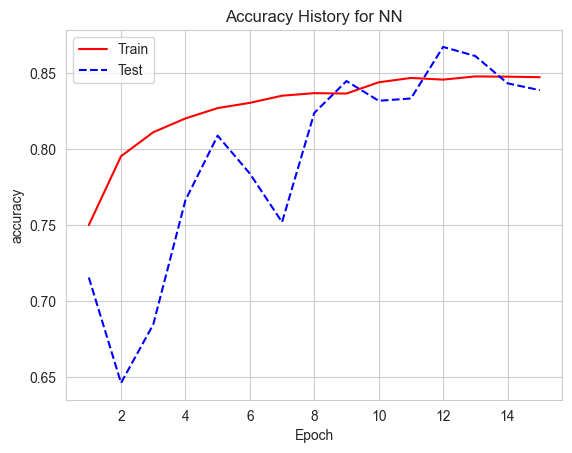

In [24]:
plot_history(history, 'NN', 'accuracy')

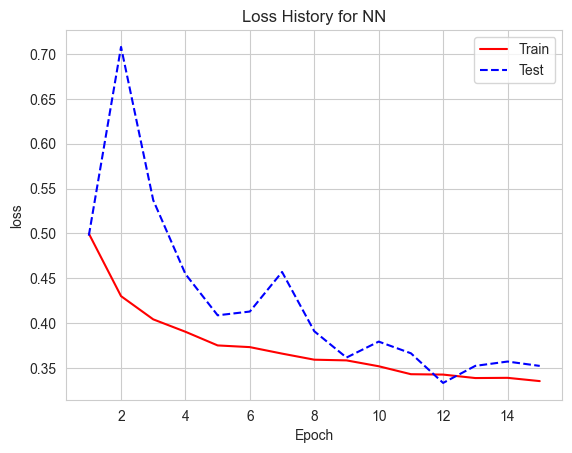

In [25]:
plot_history(history, 'NN', 'loss')

### Model Evaluation Metrics

In [26]:
predicted_probabilities = nn_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.where(predicted_probabilities > 0.5, 1, 0).astype(np.int32)

# Get true labels
true_labels = test_generator.classes

# Use the evaluate_model_performance function
accuracy, precision, recall, mse = evaluate_model_performance(true_labels, predicted_labels)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Mean Squared Error: 0.16
Accuracy: 83.90%
Precision: 91.24%
Recall: 75.00%


### Classification Report

In [27]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.79      0.93      0.85      1000
   Malignant       0.91      0.75      0.82      1000

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



### Confution Matrix

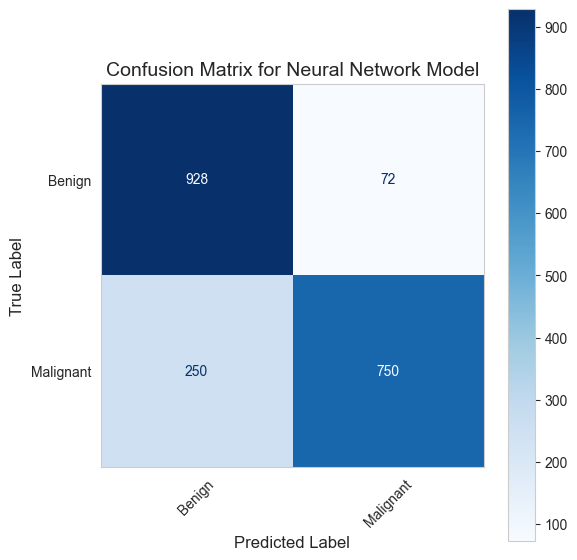

In [28]:
nn_cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=["Benign", "Malignant"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix for Neural Network Model", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
K.clear_session()

## Logistic Regression

### Creation

In [30]:
def create_logistic_regression_model(input_shape):

    model = Sequential()

    model.add(tf.keras.Input(shape=input_shape))

    model.add(Flatten())

    model.add(Dense(1))

    model.add(tf.keras.layers.Activation('sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [31]:
# Model parameters
input_shape = (img_width, img_height, 3)

# Get model
logistic_model = create_logistic_regression_model(input_shape)

# Display the model architecture
logistic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 37632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        37,633 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,633 (147.00 KB)

 Trainable params: 37,633 (147.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training and evaluating

In [32]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model with TensorBoard callback
history = logistic_model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[tensorboard_callback])

Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.6395 - loss: 0.6341 - val_accuracy: 0.6270 - val_loss: 0.6115
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.7437 - loss: 0.5292 - val_accuracy: 0.7140 - val_loss: 0.5341
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7751 - loss: 0.4967 - val_accuracy: 0.6055 - val_loss: 0.7041
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7645 - loss: 0.4997 - val_accuracy: 0.7730 - val_loss: 0.4968
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.7745 - loss: 0.4745 - val_accuracy: 0.7465 - val_loss: 0.5004
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.7810 - loss: 0.4683 - val_accuracy: 0.6685 - val_loss: 0.5843
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.7900 - loss: 0.4573 - val_accuracy: 0.7970 - val_loss: 0.4701
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.7925 - loss: 0.4523 - 

In [33]:
last_val_accuracy = history.history['val_accuracy'][-1]

print(f"Test Accuracy: {last_val_accuracy}")

Test Accuracy: 0.6784999966621399


### Training Results

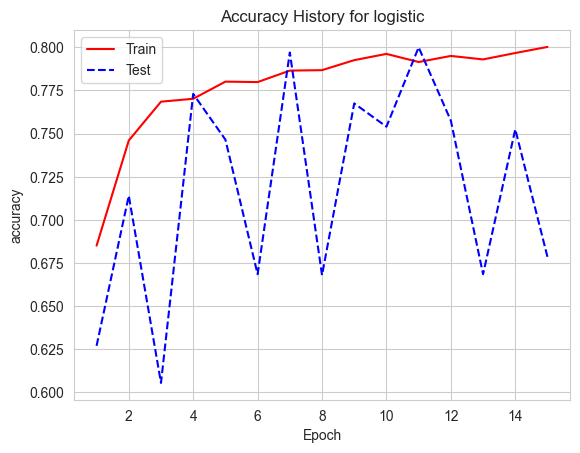

In [34]:
plot_history(history, 'logistic', 'accuracy')

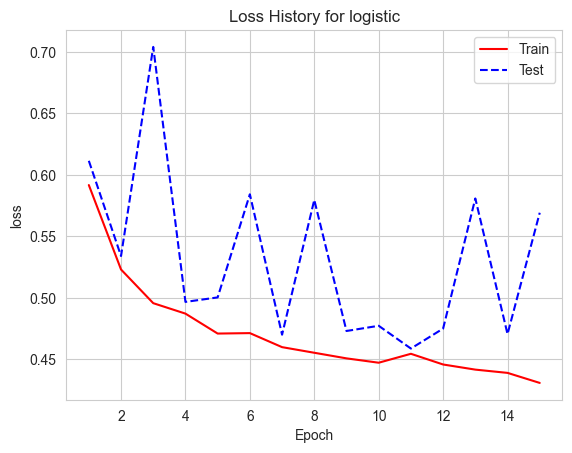

In [35]:
plot_history(history, 'logistic', 'loss')

### Model Evaluation Metrics

In [36]:
predicted_probabilities = logistic_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.where(predicted_probabilities > 0.5, 1, 0).astype(np.int32)

# Get true labels
true_labels = test_generator.classes

# Use the evaluate_model_performance function
accuracy, precision, recall, mse = evaluate_model_performance(true_labels, predicted_labels)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Mean Squared Error: 0.32
Accuracy: 67.85%
Precision: 89.40%
Recall: 40.50%


### Classification Report

In [37]:
# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.62      0.95      0.75      1000
   Malignant       0.89      0.41      0.56      1000

    accuracy                           0.68      2000
   macro avg       0.75      0.68      0.65      2000
weighted avg       0.75      0.68      0.65      2000



### Confusion Matrix

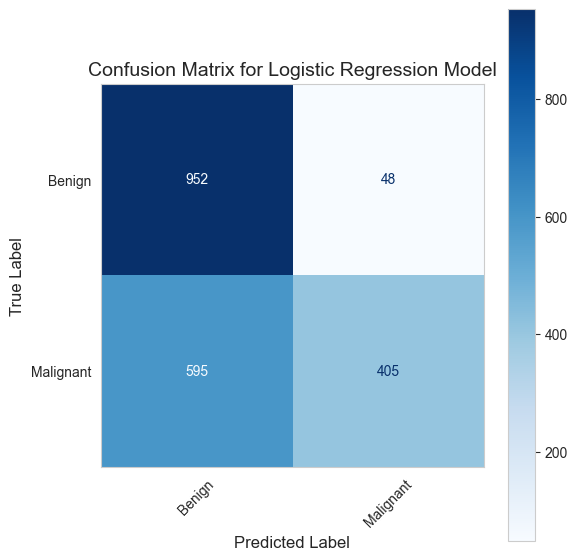

In [38]:
logistic_cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=logistic_cm, display_labels=["Benign", "Malignant"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix for Logistic Regression Model", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
K.clear_session()

## Convolutional Neural Network

### Creation

In [40]:
# יצירת המודל
def Convolutional_neural_network_model(input_shape):
    model = Sequential()  # מודל סיקוונסיאלי, בו כל השכבות ממוקמות אחת אחרי השנייה

    # שכבת קונבולוציה ראשונה
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=1, input_shape=input_shape))
    # Conv2D: שכבת קונבולוציה עם 64 פילטרים בגודל 3x3
    # activation='relu': הפונקציה הסיגמואידית relu היא פונקציית הפעלה לא לינארית
    # padding='same': כלומר הפלט יהיה באותו גודל כמו הקלט (הוספת פדינג סביב התמונה)
    # strides=1: הסטרייד (הזזה) הוא 1, כלומר נעבור על כל פיקסל בתמונה
    # input_shape: נתוני הקלט, מימדי התמונה (רוחב, גובה, ערוצים)
    model.add(BatchNormalization())  # BatchNormalization: נרמול הפלט של השכבה כדי יהיה בעל ממוצע 0 ושונות קבועה להגברת היציבות
    model.add(MaxPooling2D((2, 2), strides=2))  # MaxPooling2D: פוולינג מקסימלי בגודל 2x2 עם סטרייד של 2

    # שכבת קונבולוציה שניה
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=1))
    # Conv2D: שכבת קונבולוציה עם 128 פילטרים בגודל 3x3
    model.add(BatchNormalization())  # BatchNormalization: נרמול פנימי של השכבה
    model.add(MaxPooling2D((2, 2), strides=2))  # MaxPooling2D: פוולינג מקסימלי בגודל 2x2 עם סטרייד של 2

    # שכבת קונבולוציה שלישית
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=1))
    # Conv2D: שכבת קונבולוציה עם 256 פילטרים בגודל 3x3
    model.add(BatchNormalization())  # BatchNormalization: נרמול פנימי של השכבה
    model.add(MaxPooling2D((2, 2), strides=2))  # MaxPooling2D: פוולינג מקסימלי בגודל 2x2 עם סטרייד של 2

    # Flatten - הופכים את הפלט לווקטור שטוח (לכדי לחבר אותו לשכבות דנס)
    model.add(Flatten())
    # Flatten: הפיכת מטריצה לתשדורת אחת שטוחה (וקטור)

    # שכבת Dense עם רגוליזציה L2
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    # Dense: שכבת Fully Connected עם 512 נוירונים, פונקציית הפעלה relu
    # kernel_regularizer=l2(0.001): רגוליזציה L2 על מנת למנוע אוברפיטינג (הוספת קנס לכמות האיברים בשכבה)
    model.add(BatchNormalization())  # BatchNormalization: נרמול פנימי של השכבה
    model.add(Dropout(0.5))  # Dropout: השמטת חצי מהנוירונים בשכבה לשיפור הכללה ולמניעת אוברפיטינג

    # שכבת פלט עם פונקציית הפעלה Sigmoid עבור סיווג בינארי
    model.add(Dense(1, activation='sigmoid'))
    # Dense: שכבת פלט עם נוירון אחד
    # activation='sigmoid': פונקציית הפעלה סיגמואיד המתאימה לסיווג בינארי (הפלט בין 0 ל-1)

    # קומפילציה של המודל
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    # Adam: אופטימיזטור Adam עם קצב למידה נמוך של 0.0001
    # loss='binary_crossentropy': פונקציית הפסד לסיווג בינארי
    # metrics=['accuracy']: מדד הביצועים יהיה הדיוק

    # הגדרת הפסקה מוקדמת (EarlyStopping)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    # monitor='val_loss': המעקב יהיה אחרי מדד האובדן (loss)
    # patience=5: אם לא תהיה שיפור במשך 5 אפוקים, תבוצע הפסקה מוקדמת
    # restore_best_weights=True: תחזור למשקולות הטובות ביותר שהיו עד כה

    return model  # מחזירים את המודל שהוגדר


In [41]:
# Model parameters
input_shape = (112, 112, 3)

# Get model
cnn_model = Convolutional_neural_network_model(input_shape)

# Display the model architecture
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,219,201 (50.43 MB)

 Trainable params: 13,217,793 (50.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

### Training and evaluating

In [42]:
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model with TensorBoard callback
history = cnn_model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=[tensorboard_callback])

Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 365s 974ms/step - accuracy: 0.8243 - loss: 0.9364 - val_accuracy: 0.5480 - val_loss: 2.1855
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 355s 954ms/step - accuracy: 0.8676 - loss: 0.7189 - val_accuracy: 0.8375 - val_loss: 0.7276
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 360s 968ms/step - accuracy: 0.8774 - loss: 0.6381 - val_accuracy: 0.9120 - val_loss: 0.5279
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 341s 917ms/step - accuracy: 0.8854 - loss: 0.5607 - val_accuracy: 0.8940 - val_loss: 0.5061
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 323s 868ms/step - accuracy: 0.8961 - loss: 0.4955 - val_accuracy: 0.9145 - val_loss: 0.4491
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 314s 843ms/step - accuracy: 0.8887 - loss: 0.4710 - val_accuracy: 0.9230 - val_loss: 0.3958
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 313s 842ms/step - accuracy: 0.9040 - loss: 0.4193 - val_accuracy: 0.9320 - val_loss: 0.3682
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 313s 842ms/step - accuracy: 0.9114 -

In [43]:
last_val_accuracy = history.history['val_accuracy'][-1]

print(f"Test Accuracy: {last_val_accuracy}")

Test Accuracy: 0.9235000014305115


### Training Results

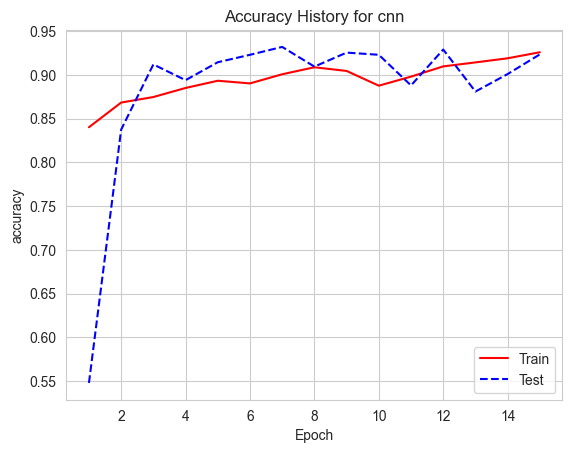

In [44]:
plot_history(history, 'cnn', 'accuracy')

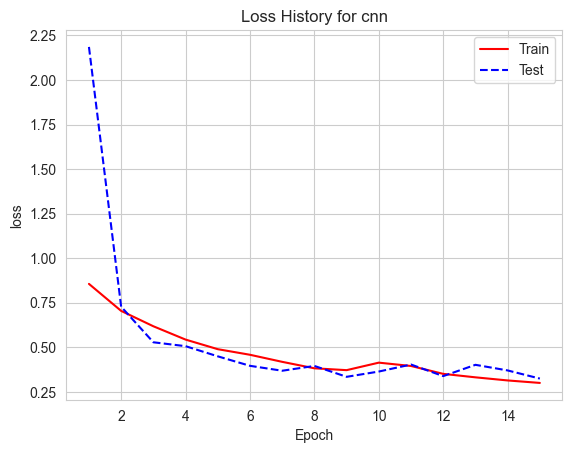

In [45]:
plot_history(history, 'cnn', 'loss')

### Model Evaluation Metrics

In [46]:
predicted_probabilities = cnn_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
predicted_labels = np.where(predicted_probabilities > 0.5, 1, 0).astype(np.int32)

# Get true labels
true_labels = test_generator.classes

# Use the evaluate_model_performance function
accuracy, precision, recall, mse = evaluate_model_performance(true_labels, predicted_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step
Mean Squared Error: 0.08
Accuracy: 92.35%
Precision: 92.56%
Recall: 92.10%


### Classification Report

In [47]:
report = classification_report(true_labels, predicted_labels, target_names=["Benign", "Malignant"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Benign       0.92      0.93      0.92      1000
   Malignant       0.93      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



### Confusion Matrix

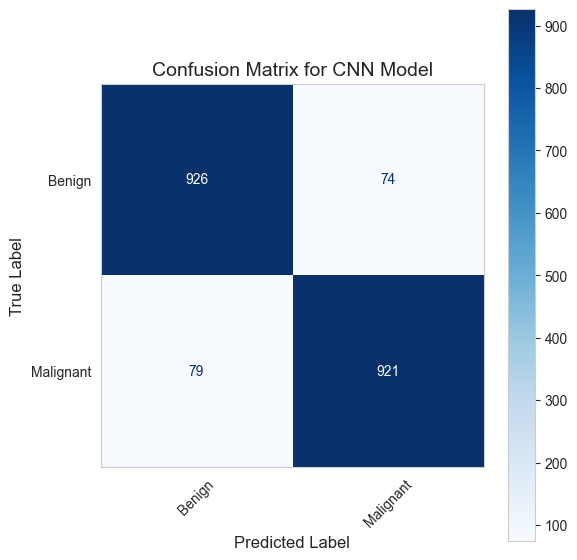

In [48]:
cnn_cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=["Benign", "Malignant"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
plt.title("Confusion Matrix for CNN Model", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Report

## Prediction Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


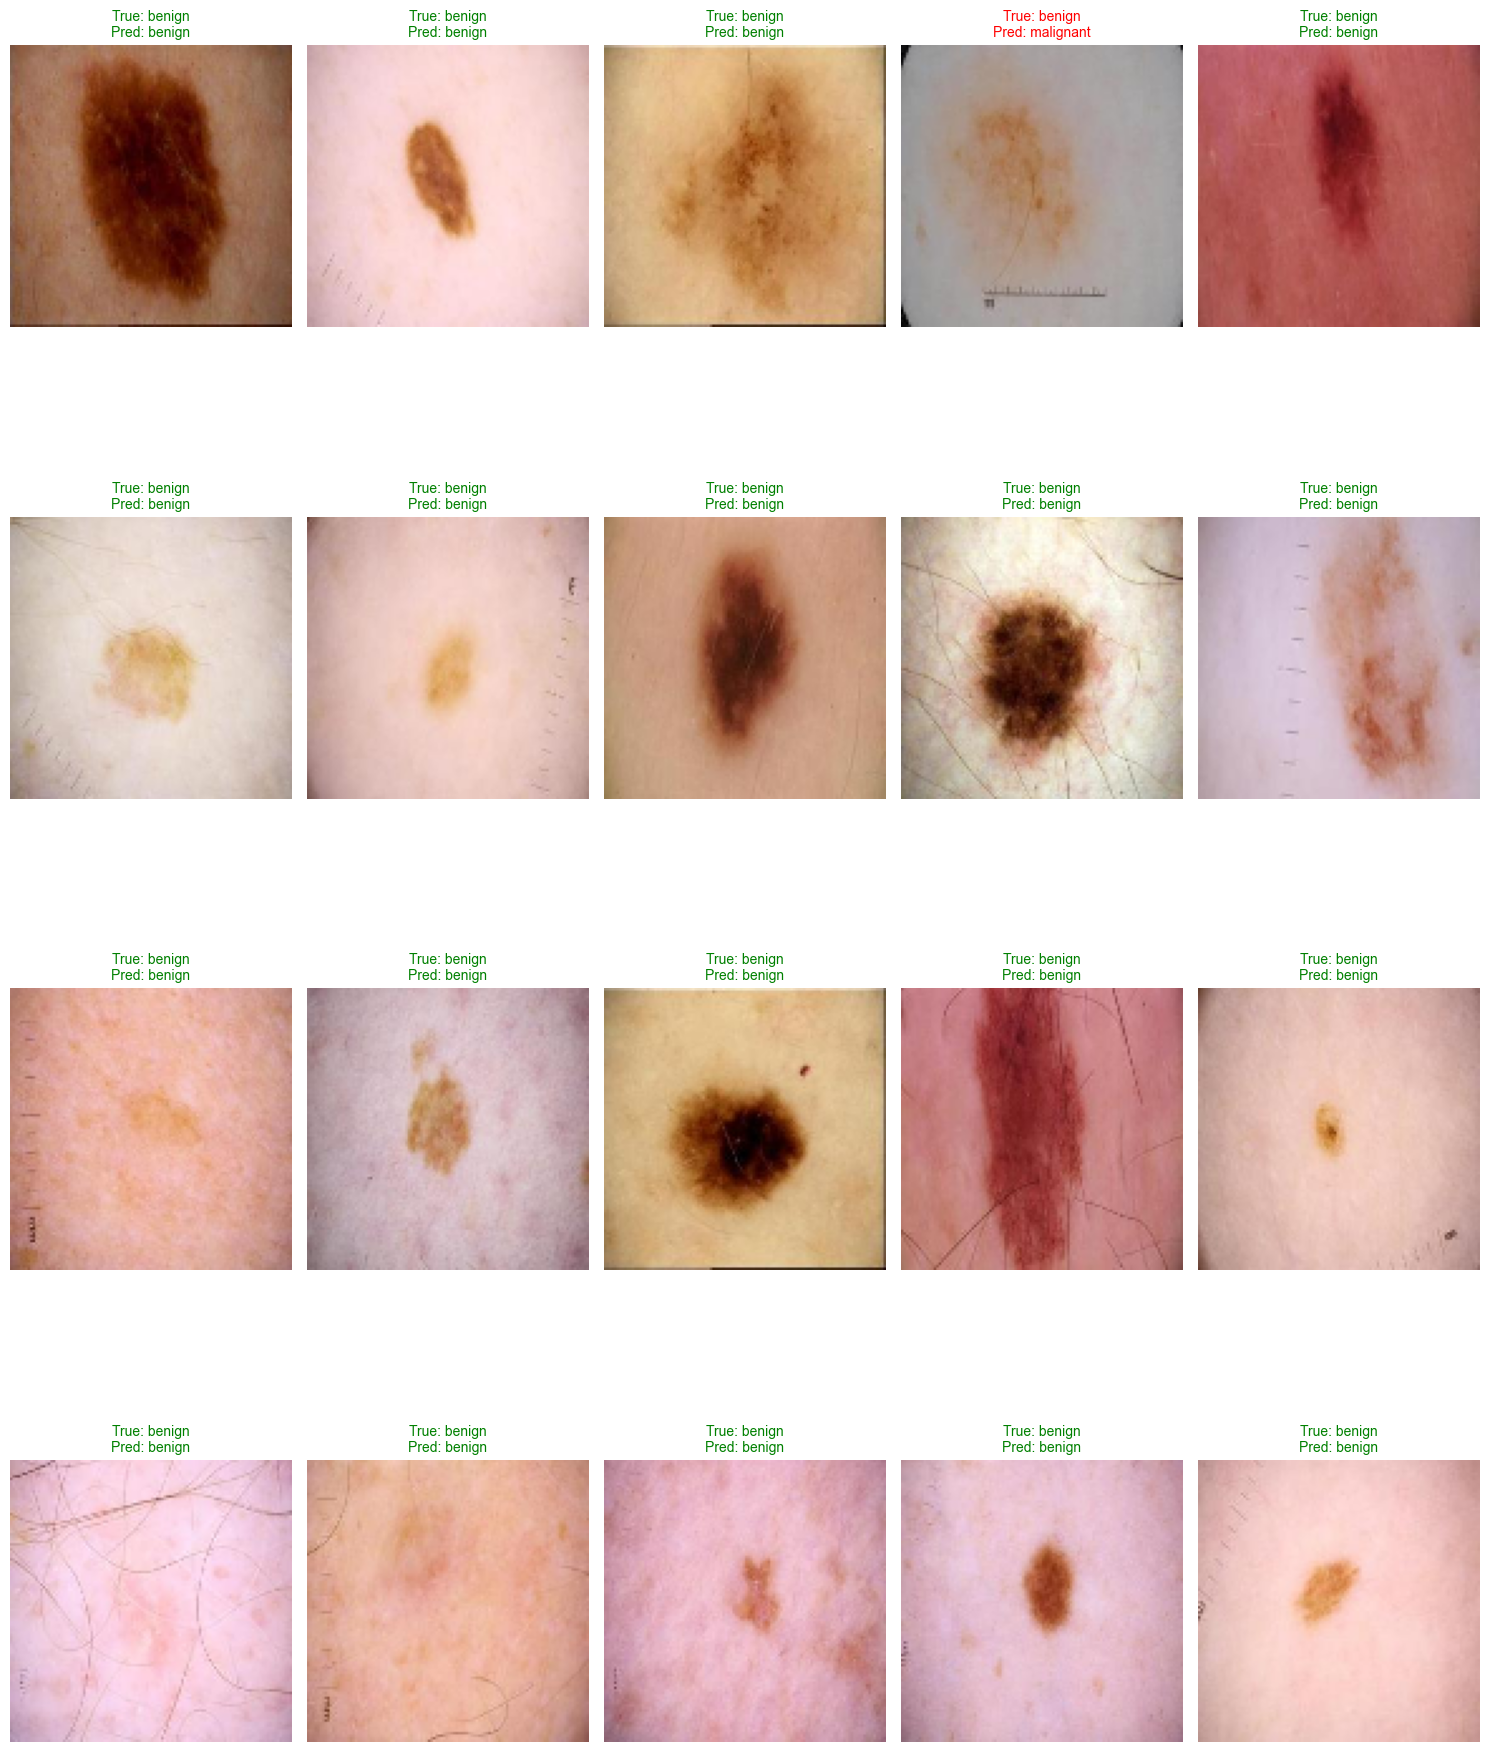

In [49]:
num_images = 20
images, labels = next(test_generator)
predictions = cnn_model.predict(images)
cols = 5
rows = num_images // cols + (num_images % cols > 0)

plt.figure(figsize=(15, 5 * rows))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label = "malignant" if labels[i] == 1 else "benign"
    predicted_label = "malignant" if predictions[i] > 0.5 else "benign"

    color = "green" if true_label == predicted_label else "red"

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color, fontsize=10)

plt.tight_layout()
plt.show()